In [1]:
import torch
import torchvision
import pandas as pd
from torch.utils import data
import torchvision.models as models
import numpy as np
import random
import glob
from pathlib import Path
import os
import PIL
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


from torchvision import transforms
from torch.utils.data import Dataset,DataLoader

In [2]:
main_path = 'Fish_Dataset/Fish_Dataset'

In [3]:
path = Path(main_path)
img_dir_path = list(path.glob('**/*.png'))# images are in png file format

images_paths = [img_path for img_path in img_dir_path if 'GT' not in str(img_path)]
print(f'Number of training images :{len(images_paths)}')

labels = [os.path.split(os.path.split(name)[0])[1] for name in images_paths]
print(f'Number of labels :{len(labels)}')

classes = list(set(labels))
label_encoder = {label : i for i,label in enumerate(classes)}
print('-'*404)
print(f'Label Encoder :{label_encoder}')
labels_encoded = [label_encoder[label] for label in labels]

Number of training images :9000
Number of labels :9000
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Label Encoder :{'Shrimp': 0, 'Red Sea Bream': 1, 'Hourse Mackerel': 2, 'Trout': 3, 'Red Mullet': 4, 'Sea Bass': 5, 'Striped Red Mullet': 6, 'Black Sea Sprat': 7, 'Gilt-Head Bream': 8}


In [4]:
rand_img_paths = []
for i in classes:
    path =  os.path.join(os.path.join(main_path,i),i)
    rand_path = list(glob.glob(path+'/*')[:5])
    rand_img_paths.append(rand_path)

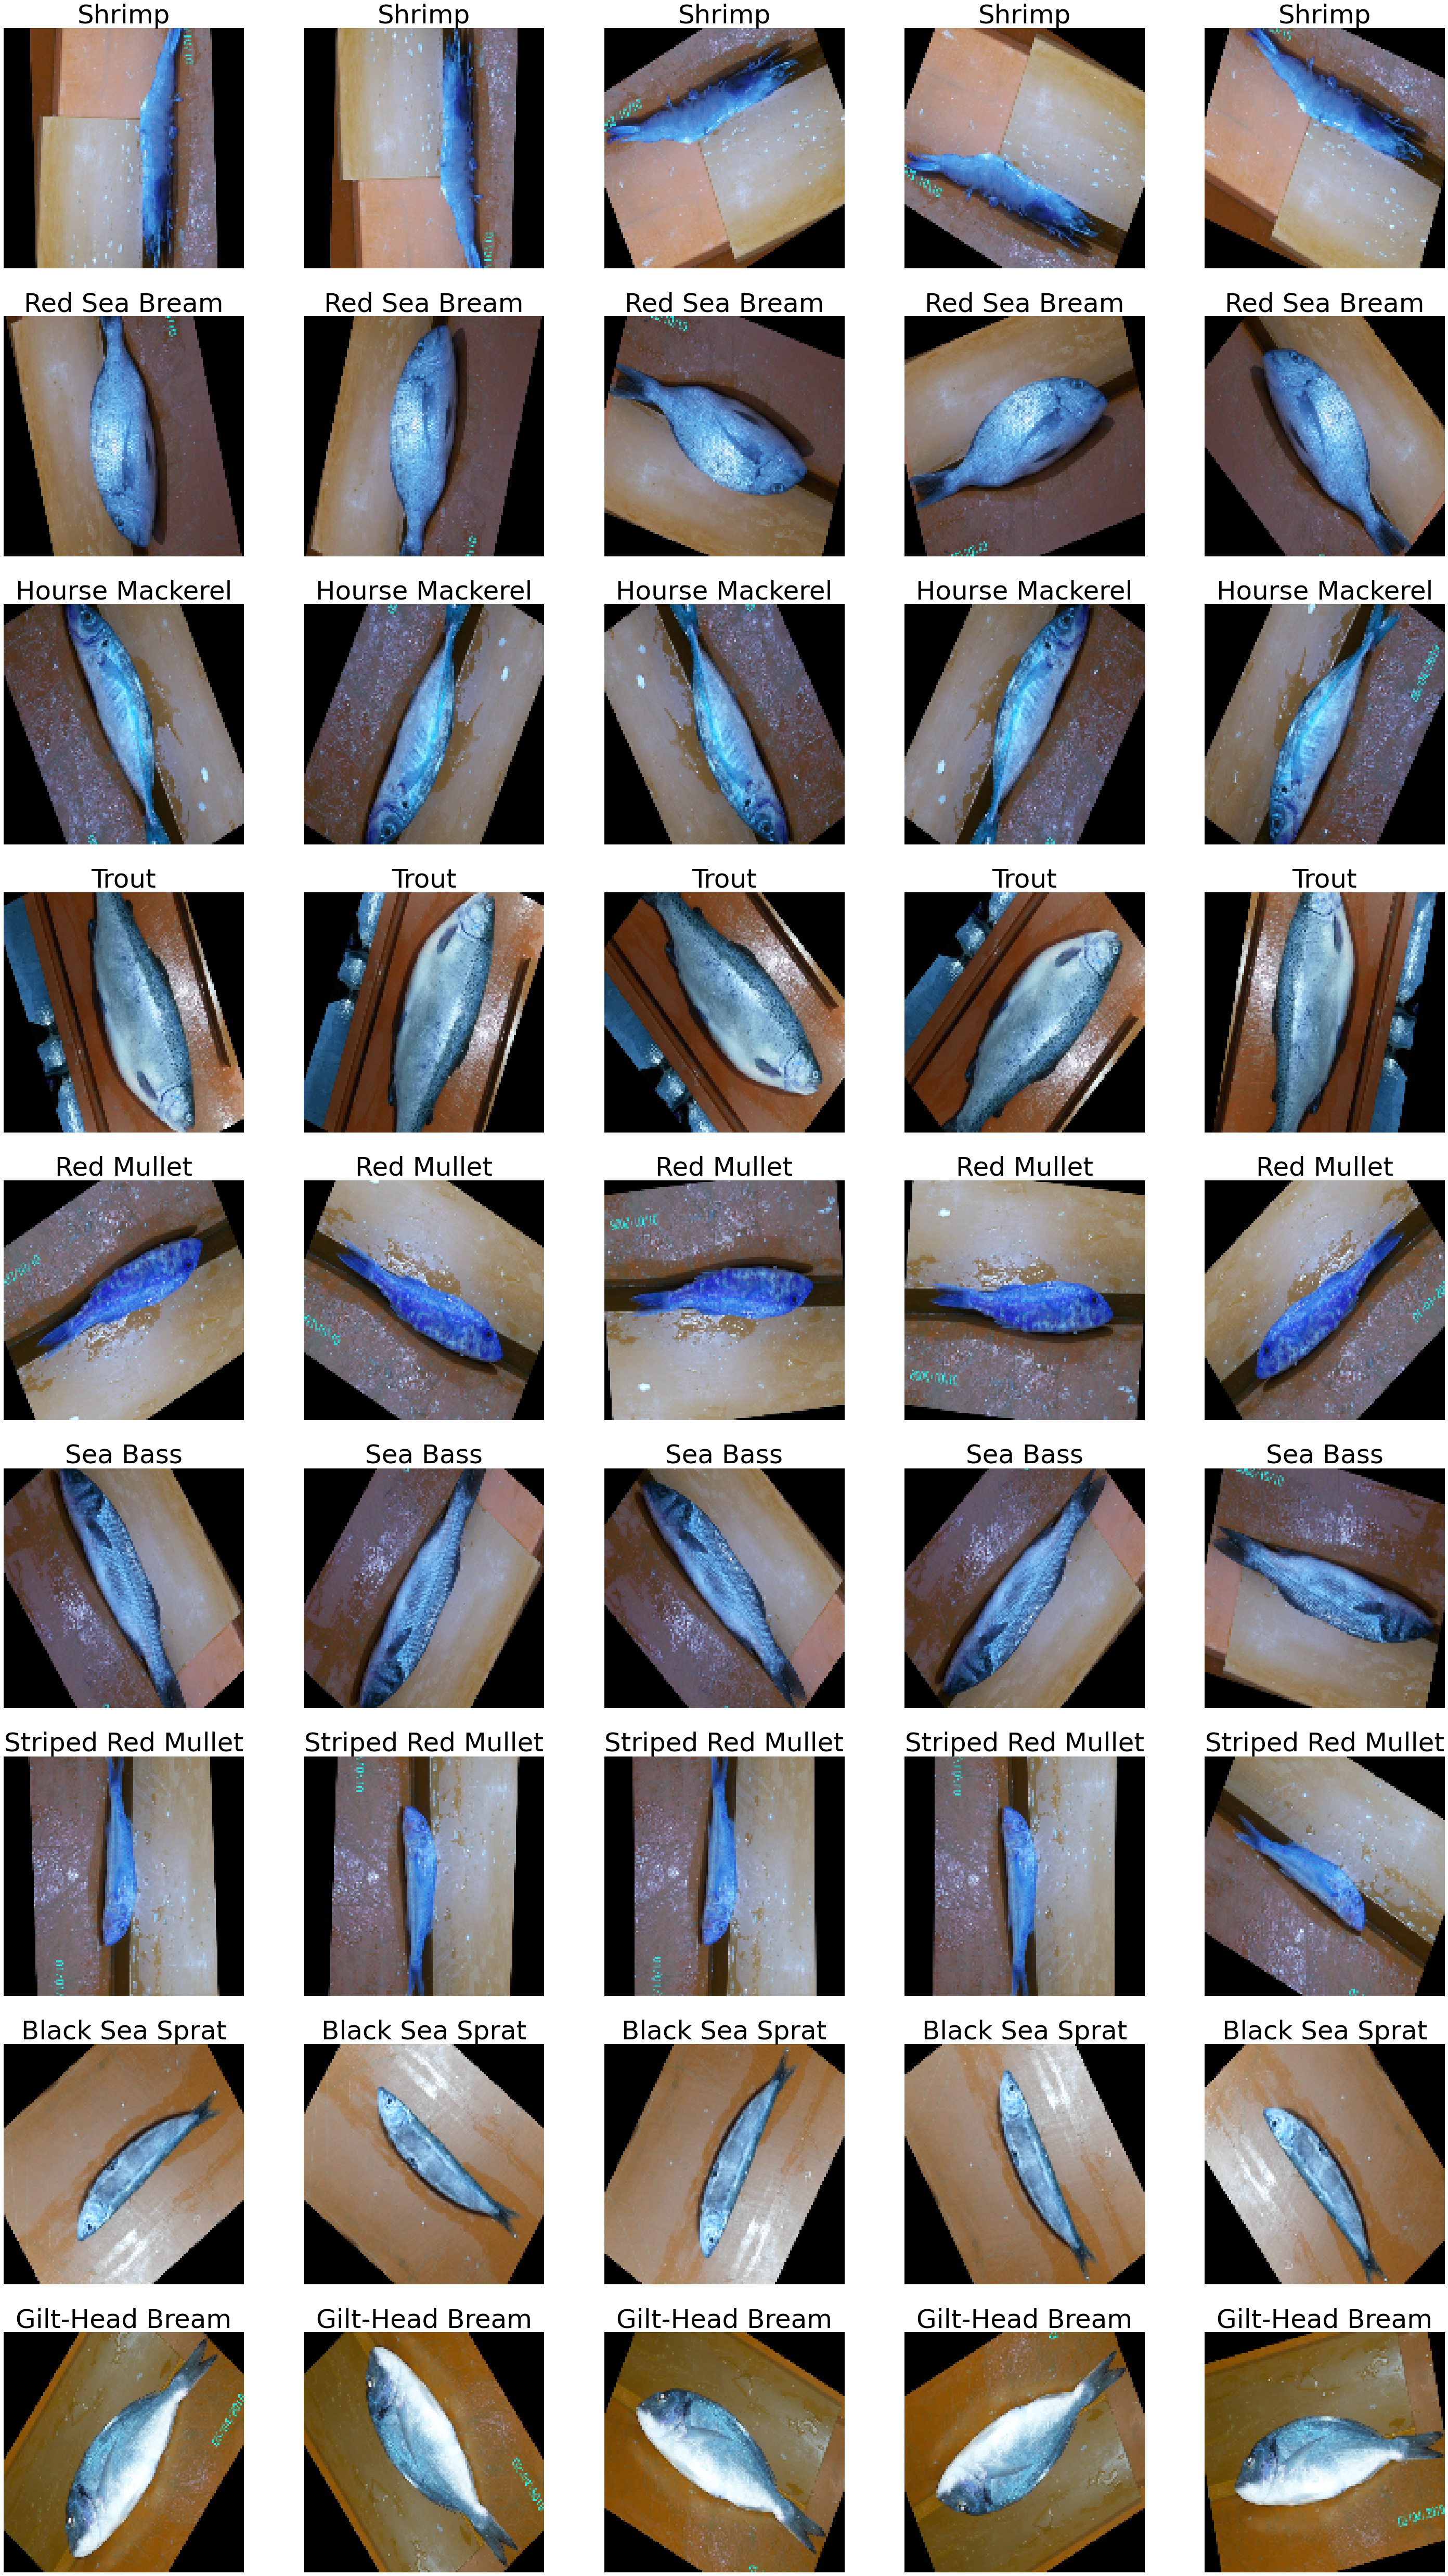

In [5]:
import cv2
fig=plt.figure(figsize=(50, 90))
columns = 5; rows = 9
num=1
for i in range(len(classes)):
    for j in range(len(rand_img_paths[i])):
        img = cv2.imread(rand_img_paths[i][j])
        img = cv2.resize(img, (128, 128))
        fig.add_subplot(rows, columns, num)
        num+=1
        plt.title(classes[i],fontsize=50)
        plt.imshow(img)
        plt.axis(False)

In [6]:
class fishDataset(Dataset):
    def __init__(self,images,labels,transform):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        input_image = self.images[idx]
        label = self.labels[idx]
        image = PIL.Image.open(input_image)
        image = self.transform(image)
        return image,label

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data , test_data, labels, test_labels = train_test_split(images_paths, labels_encoded, test_size=0.2, shuffle=True)
#Split train data for train and validation
train_data , val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, shuffle=True)

In [9]:
batch_size = 32

train_ds = fishDataset(
        images=train_data,
        labels=train_labels,
        transform=data_transforms['train'])

train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True)


val_ds = fishDataset(
        images=val_data,
        labels=val_labels,
        transform=data_transforms['val']
)

val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False
)

test_ds = fishDataset(
        images=test_data,
        labels=test_labels,
        transform=data_transforms['val']
)

test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False
)

In [10]:
labels_dic = {i : label for i,label in enumerate(classes)}
def show_batch(loader, batch_size, labels_dic):
    rows_number = 1
    cols_number = 2
    if batch_size > 2:
        cols_number = 8
        rows_number = batch_size//cols_number
        
    fig = plt.figure(figsize=(48, 30))
    images,labels = next(iter(loader))
    for i,data in enumerate(images,1):
        ax = fig.add_subplot(rows_number, cols_number, i)
        plt.imshow(data.permute(1,2,0).numpy())
        ax.set_title(labels_dic[labels[i-1].item()],fontsize = 20)
        plt.axis(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

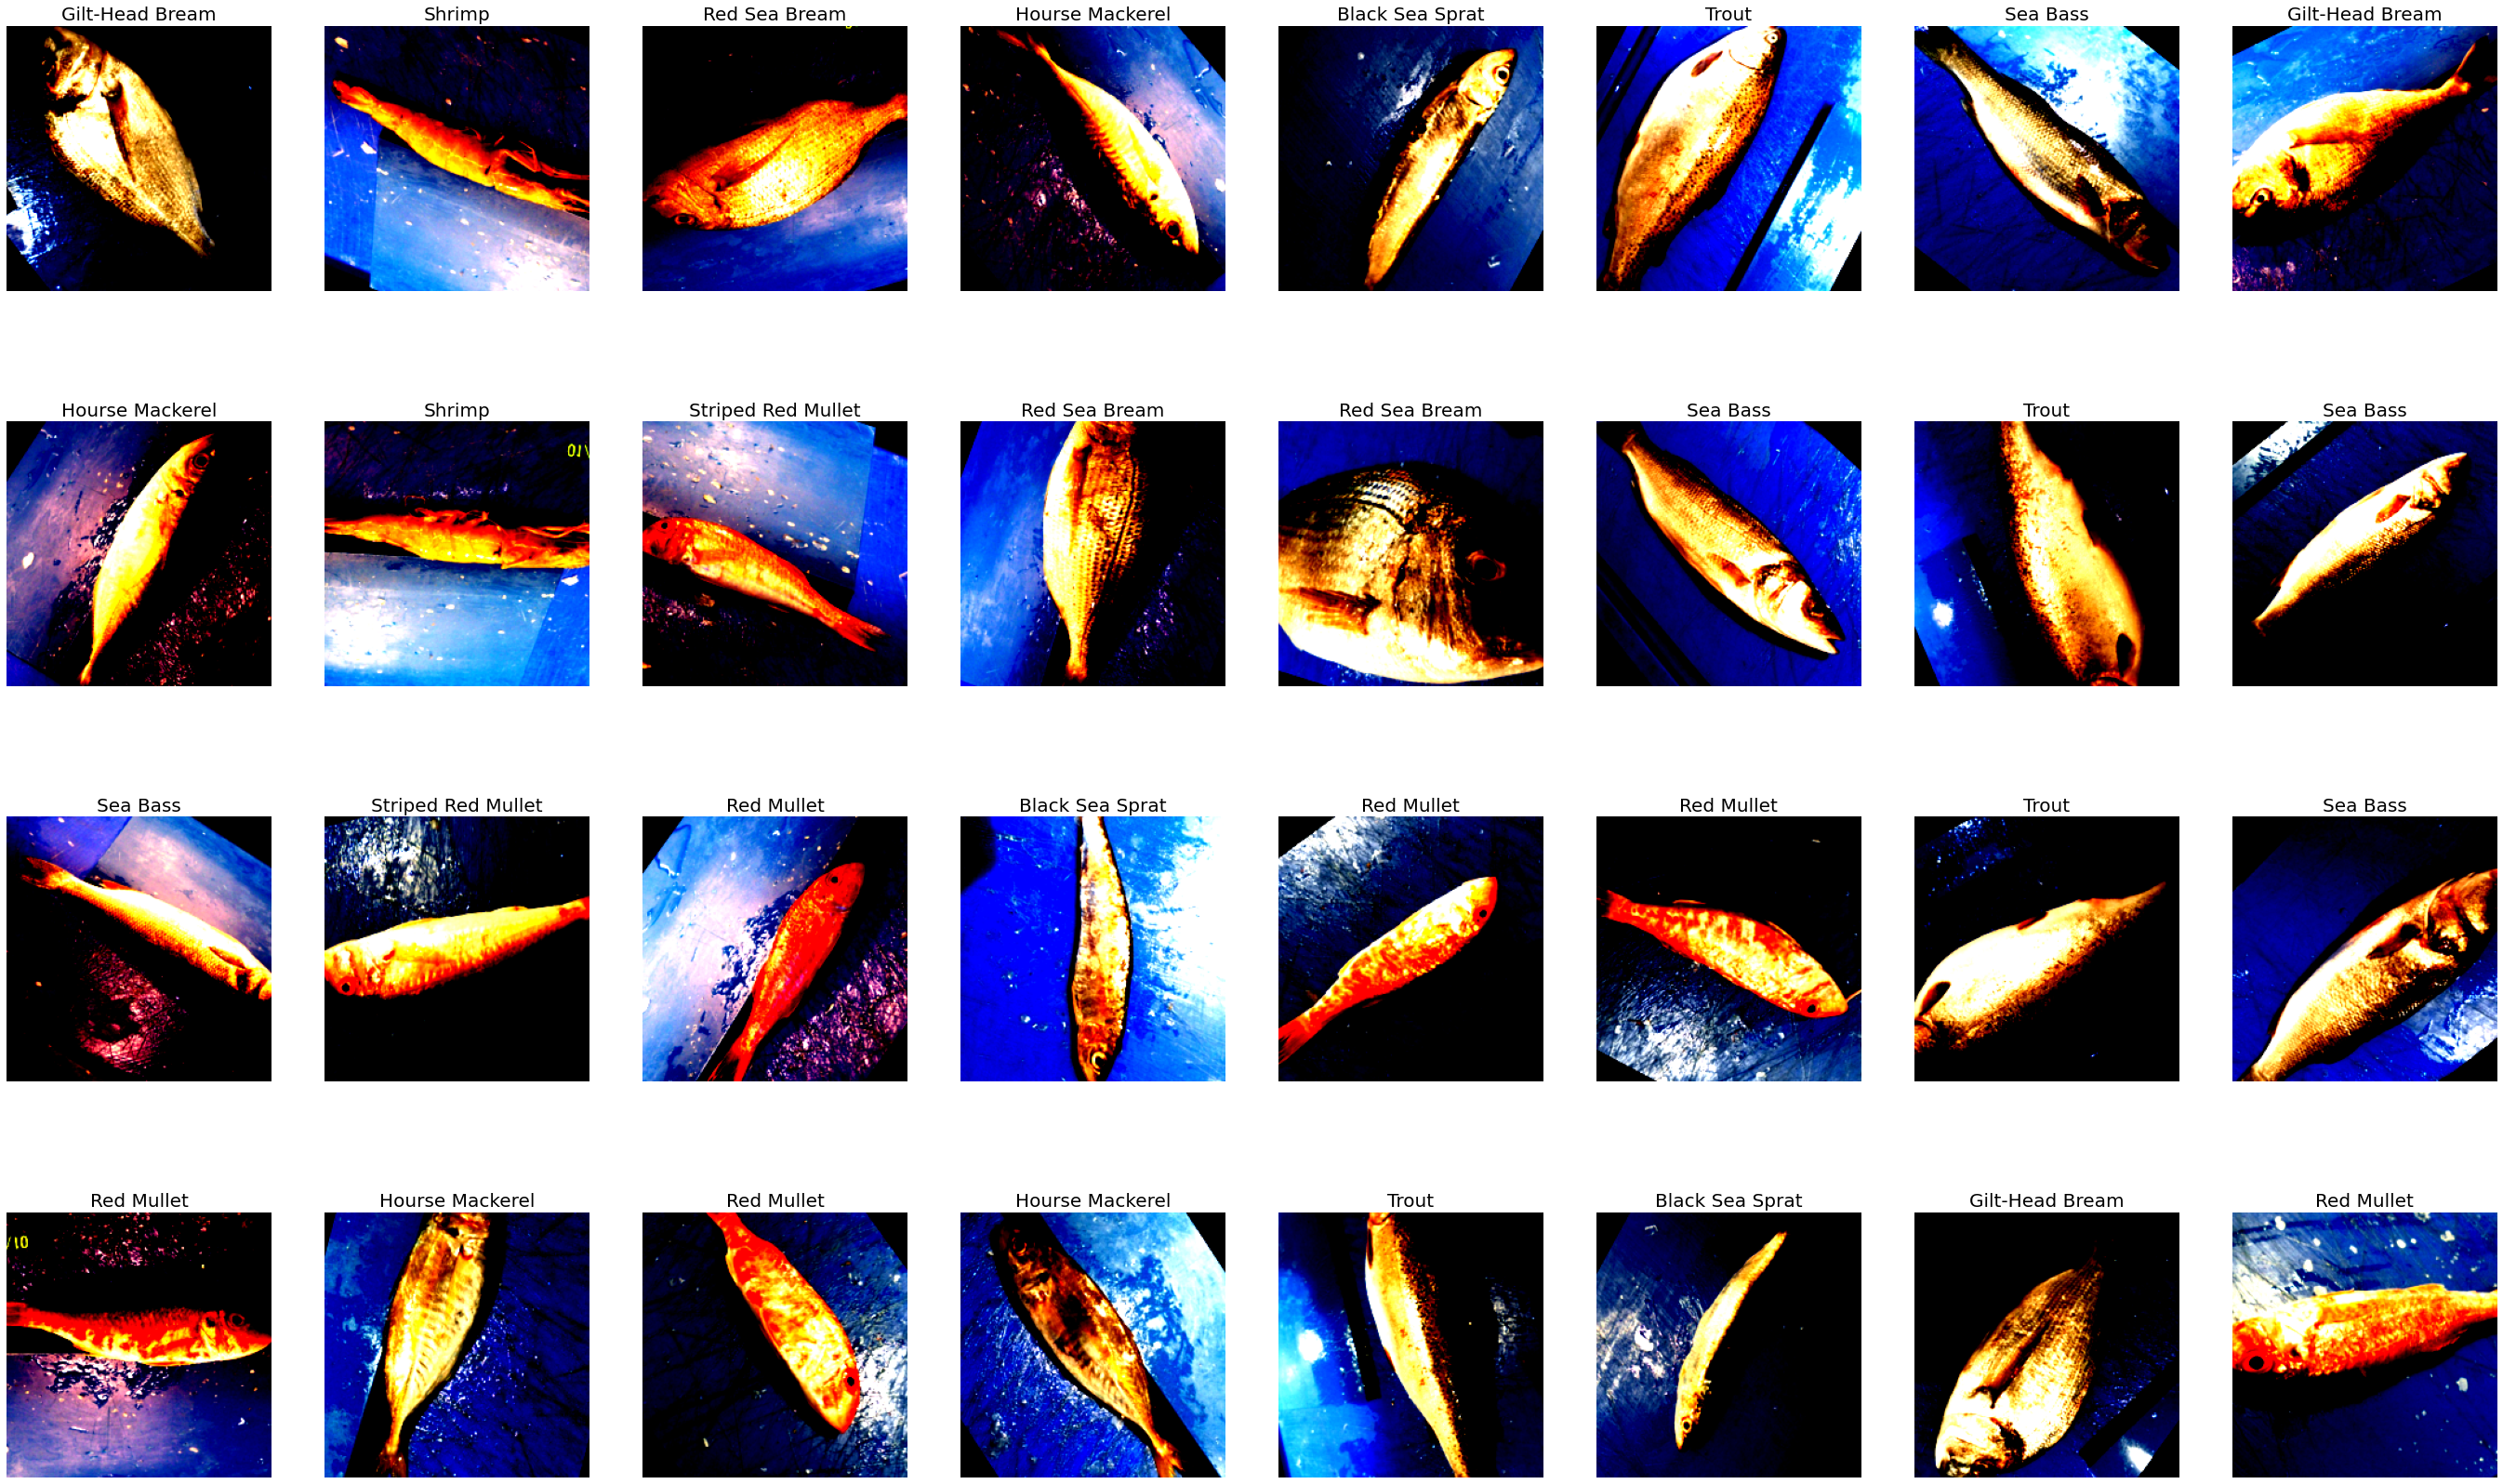

In [11]:
show_batch(train_loader, batch_size, labels_dic)# We want to look at the data

In [12]:
#Modelling Stage

In [13]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features,9)
for param in model.fc.parameters():
    param.requires_grad = True

In [14]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [15]:
optimizer = torch.optim.Adam(model.fc.parameters(),lr= 0.001)
criterion = torch.nn.CrossEntropyLoss()

In [16]:
model = model.to(device)

In [17]:
#Training Stage

In [18]:
from tqdm import tqdm
n_epochs = 25
valid_loss_min = np.Inf
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []
for epoch in tqdm(range(1,n_epochs+1)):
    train_loss = 0.0
    valid_loss = 0.0
    train_running_correct= 0.0
    val_running_correct = 0.0
    
    model.train()
    
    for data,target in train_loader:
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        _,preds = torch.max(output.data,1)
        train_running_correct += (preds==target).sum().item()
    
    model.eval()
    for data,target in val_loader:
        data,target = data.to(device),target.to(device)
        output = model(data)
        loss = criterion(output,target)
        valid_loss+=loss.item()*data.size(0)
        _,preds =torch.max(output.data,1)
        val_running_correct += (preds==target).sum().item()
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    train_accuracy = 100. * train_running_correct/len(train_loader.sampler)
    valid_accuracy = 100. * val_running_correct/len(val_loader.sampler)
    print('Epoch: {} , Training Loss: {:.6f},Training Accuracy: {:.3f} ,Validation Loss: {:.6f}, Validation Accuracy: {:.3f}'.format(epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
    
    if valid_loss<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_fish.pt')
        valid_loss_min = valid_loss
    train_acc_history.append(train_accuracy)
    val_acc_history.append(valid_accuracy)
    train_loss_history.append(train_loss)
    val_loss_history.append(valid_loss)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\William\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  4%|▍         | 1/25 [01:38<39:22, 98.43s/it]

Epoch: 1 , Training Loss: 0.753545,Training Accuracy: 84.219 ,Validation Loss: 0.235154, Validation Accuracy: 98.056
Validation loss decreased (inf --> 0.235154).  Saving model ...


  8%|▊         | 2/25 [03:15<37:21, 97.44s/it]

Epoch: 2 , Training Loss: 0.191076,Training Accuracy: 98.177 ,Validation Loss: 0.115492, Validation Accuracy: 98.958
Validation loss decreased (0.235154 --> 0.115492).  Saving model ...


 12%|█▏        | 3/25 [04:51<35:35, 97.08s/it]

Epoch: 3 , Training Loss: 0.116091,Training Accuracy: 98.403 ,Validation Loss: 0.081054, Validation Accuracy: 99.028
Validation loss decreased (0.115492 --> 0.081054).  Saving model ...


 16%|█▌        | 4/25 [06:28<33:56, 96.98s/it]

Epoch: 4 , Training Loss: 0.085902,Training Accuracy: 98.941 ,Validation Loss: 0.063090, Validation Accuracy: 98.889
Validation loss decreased (0.081054 --> 0.063090).  Saving model ...


 20%|██        | 5/25 [08:06<32:27, 97.39s/it]

Epoch: 5 , Training Loss: 0.066693,Training Accuracy: 99.097 ,Validation Loss: 0.057482, Validation Accuracy: 99.167
Validation loss decreased (0.063090 --> 0.057482).  Saving model ...


 24%|██▍       | 6/25 [09:44<30:50, 97.39s/it]

Epoch: 6 , Training Loss: 0.053922,Training Accuracy: 99.340 ,Validation Loss: 0.045252, Validation Accuracy: 99.167
Validation loss decreased (0.057482 --> 0.045252).  Saving model ...


 28%|██▊       | 7/25 [11:21<29:09, 97.21s/it]

Epoch: 7 , Training Loss: 0.048627,Training Accuracy: 99.253 ,Validation Loss: 0.036822, Validation Accuracy: 99.306
Validation loss decreased (0.045252 --> 0.036822).  Saving model ...


 32%|███▏      | 8/25 [12:57<27:30, 97.11s/it]

Epoch: 8 , Training Loss: 0.041154,Training Accuracy: 99.375 ,Validation Loss: 0.032211, Validation Accuracy: 99.167
Validation loss decreased (0.036822 --> 0.032211).  Saving model ...


 36%|███▌      | 9/25 [14:35<25:53, 97.12s/it]

Epoch: 9 , Training Loss: 0.035512,Training Accuracy: 99.514 ,Validation Loss: 0.028340, Validation Accuracy: 99.583
Validation loss decreased (0.032211 --> 0.028340).  Saving model ...


 40%|████      | 10/25 [16:12<24:19, 97.31s/it]

Epoch: 10 , Training Loss: 0.032384,Training Accuracy: 99.427 ,Validation Loss: 0.022651, Validation Accuracy: 99.792
Validation loss decreased (0.028340 --> 0.022651).  Saving model ...


 44%|████▍     | 11/25 [17:50<22:44, 97.47s/it]

Epoch: 11 , Training Loss: 0.030372,Training Accuracy: 99.462 ,Validation Loss: 0.025875, Validation Accuracy: 99.375


 48%|████▊     | 12/25 [19:30<21:16, 98.21s/it]

Epoch: 12 , Training Loss: 0.026772,Training Accuracy: 99.653 ,Validation Loss: 0.023522, Validation Accuracy: 99.653


 52%|█████▏    | 13/25 [21:10<19:46, 98.87s/it]

Epoch: 13 , Training Loss: 0.023498,Training Accuracy: 99.688 ,Validation Loss: 0.018183, Validation Accuracy: 99.792
Validation loss decreased (0.022651 --> 0.018183).  Saving model ...


 56%|█████▌    | 14/25 [22:49<18:06, 98.75s/it]

Epoch: 14 , Training Loss: 0.021836,Training Accuracy: 99.635 ,Validation Loss: 0.020869, Validation Accuracy: 99.583


 60%|██████    | 15/25 [24:26<16:23, 98.40s/it]

Epoch: 15 , Training Loss: 0.018940,Training Accuracy: 99.740 ,Validation Loss: 0.021157, Validation Accuracy: 99.583


 64%|██████▍   | 16/25 [26:04<14:43, 98.14s/it]

Epoch: 16 , Training Loss: 0.018139,Training Accuracy: 99.792 ,Validation Loss: 0.014747, Validation Accuracy: 99.792
Validation loss decreased (0.018183 --> 0.014747).  Saving model ...


 68%|██████▊   | 17/25 [27:42<13:04, 98.12s/it]

Epoch: 17 , Training Loss: 0.016994,Training Accuracy: 99.861 ,Validation Loss: 0.017303, Validation Accuracy: 99.514


 72%|███████▏  | 18/25 [29:20<11:26, 98.07s/it]

Epoch: 18 , Training Loss: 0.019091,Training Accuracy: 99.583 ,Validation Loss: 0.014598, Validation Accuracy: 99.792
Validation loss decreased (0.014747 --> 0.014598).  Saving model ...


 76%|███████▌  | 19/25 [30:58<09:48, 98.00s/it]

Epoch: 19 , Training Loss: 0.016706,Training Accuracy: 99.670 ,Validation Loss: 0.018687, Validation Accuracy: 99.653


 80%|████████  | 20/25 [32:36<08:09, 97.94s/it]

Epoch: 20 , Training Loss: 0.014062,Training Accuracy: 99.913 ,Validation Loss: 0.018018, Validation Accuracy: 99.514


 84%|████████▍ | 21/25 [34:14<06:32, 98.17s/it]

Epoch: 21 , Training Loss: 0.014406,Training Accuracy: 99.792 ,Validation Loss: 0.011186, Validation Accuracy: 99.861
Validation loss decreased (0.014598 --> 0.011186).  Saving model ...


 88%|████████▊ | 22/25 [35:53<04:54, 98.17s/it]

Epoch: 22 , Training Loss: 0.011112,Training Accuracy: 99.896 ,Validation Loss: 0.014837, Validation Accuracy: 99.583


 92%|█████████▏| 23/25 [37:31<03:16, 98.19s/it]

Epoch: 23 , Training Loss: 0.012111,Training Accuracy: 99.826 ,Validation Loss: 0.011178, Validation Accuracy: 99.861
Validation loss decreased (0.011186 --> 0.011178).  Saving model ...


 96%|█████████▌| 24/25 [39:09<01:38, 98.16s/it]

Epoch: 24 , Training Loss: 0.013885,Training Accuracy: 99.757 ,Validation Loss: 0.010947, Validation Accuracy: 99.722
Validation loss decreased (0.011178 --> 0.010947).  Saving model ...


100%|██████████| 25/25 [40:47<00:00, 97.92s/it]

Epoch: 25 , Training Loss: 0.011935,Training Accuracy: 99.861 ,Validation Loss: 0.015215, Validation Accuracy: 99.514


In [19]:
def plot_losses(history):
    losses = [x for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

def plot_accuracies(history):
    accuracies = [x for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

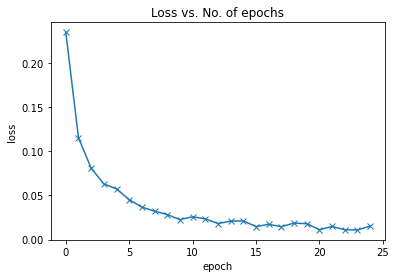

In [20]:
plot_losses(val_loss_history)

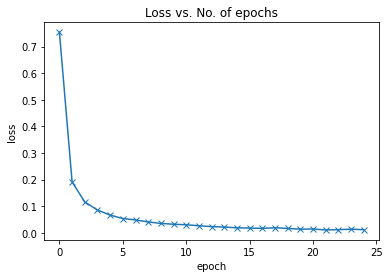

In [21]:
plot_losses(train_loss_history)

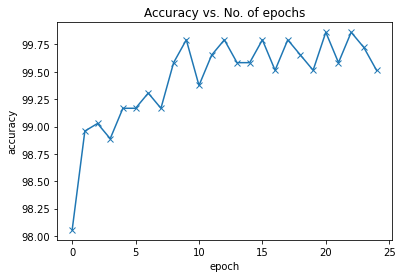

In [22]:
plot_accuracies(val_acc_history)

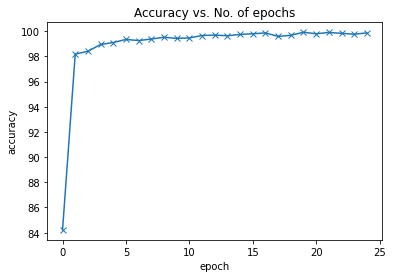

In [23]:
plot_accuracies(train_acc_history)

In [24]:
#Testing stage

In [25]:
def eval_accuracy(loader):  
    model.eval()
    corrects = 0
    total = 0
    pred_hist = []
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        predict = torch.max(predictions.data, 1)[1].to(device)
        #print("labels: ", labels)
        #print("predict :", predict)
        total += len(labels)
        corrects += (predict == labels).sum()
        for i in range(len(predict)):
            pred_hist.append(predict[i].cpu())
    #print(np.shape(pred_hist))
    accuracy = 100 * corrects / float(total)
    return accuracy, pred_hist

In [26]:
val_acc,_ = eval_accuracy(val_loader)
train_acc,_ = eval_accuracy(train_loader)
test_acc,y_pred = eval_accuracy(test_loader)

print(f' Accuracy on validation images: {val_acc}')
print(f' Accuracy on train images: {train_acc}')
print(f' Accuracy on test images: {test_acc}')

 Accuracy on validation images: 99.72222137451172
 Accuracy on train images: 99.96527862548828
 Accuracy on test images: 99.66667175292969


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      0.99      0.99       217
           2       1.00      0.99      1.00       185
           3       1.00      1.00      1.00       204
           4       1.00      1.00      1.00       198
           5       1.00      1.00      1.00       202
           6       1.00      1.00      1.00       199
           7       0.99      1.00      0.99       202
           8       0.99      1.00      0.99       204

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



In [28]:
classes=[i for i in range(9)]
con_mat_df = pd.DataFrame(confusion_matrix(test_labels,y_pred),
                     index = classes, 
                     columns = classes)

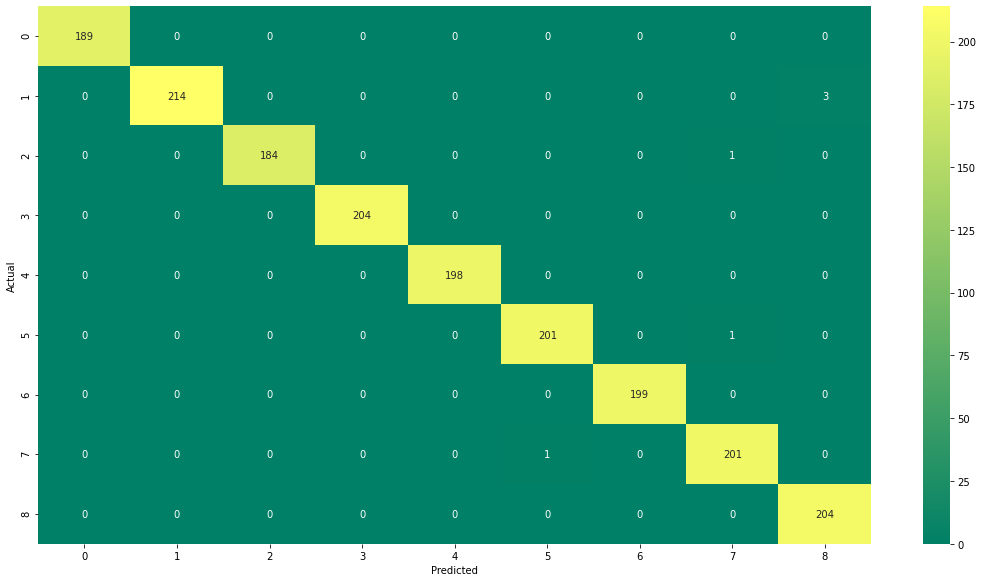

In [30]:
figure = plt.figure(figsize=(15, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.summer,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()